**Title:** NOVA Dataset Creation  
**Name:** Daniel Cavazos, Million Werede  
**Date of Creation (MM/DD/YYYY):** 04/19/2023  
**Summary** Code to take data from wikipedia, NIST CSF files, and custom made articles and convert them into an encoded dataset for use by the OpenAI API.

## Table of Contents
1. [Gather Info From NIST CSF](#nist_info)
2. [Gather Info From Wikipedia](#wiki_info)
3. [Create Meta Articles](#meta_info)
4. [Format and Encode Articles](#format_encode)

In [1]:
# necessary imports
# from imports
from transformers import GPT2TokenizerFast
from nltk.tokenize import sent_tokenize
from scipy import spatial

# alias imports
import sqlite3 as sql
import pandas as pd
import matplotlib.pyplot as plt

# standard imports
import os
import wikipedia
import re
import ast
import tiktoken
import openai

c:\Users\Daniel\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<a id='nist_info'></a>  
## Gather Info From NIST CSF

This section is responsible for collecting information from the file `nist.db`. For code on the creation of this sqlite database, see the file `nist_database.ipynb`.

In [2]:
db_path = 'data/nist.db' # get database path for later

In [3]:
def create_nist_info_dict(name=None,
                          abbrev=None,
                          summary=None,
                          guidance=None,
                          related_to=None,
                          nist_type=None):
    """
    Creates a dictionary containing NIST (National Institute of Standards and Technology) information.

    Args:
        name (str, optional): The name of the NIST item. Defaults to None.
        abbrev (str, optional): The abbreviation or acronym of the NIST item. Defaults to None.
        summary (str, optional): A brief summary or description of the NIST item. Defaults to None.
        guidance (str, optional): Guidance or recommendations related to the NIST item. Defaults to None.
        related_to (str, optional): Other items related to the NIST item. Defaults to None.
        nist_type (str, optional): The type or category of the NIST item. Defaults to None.

    Returns:
        dict: A dictionary containing the NIST information with the following keys:
            - 'name': The name of the NIST item.
            - 'abbrev': The abbreviation or acronym of the NIST item.
            - 'summary': A brief summary or description of the NIST item.
            - 'guidance': Guidance or recommendations related to the NIST item.
            - 'related_to': Other items related to the NIST item.
            - 'nist_type': The type or category of the NIST item.
    """
    return {
        'name': name,
        'abbrev': abbrev,
        'summary': summary,
        'guidance': guidance,
        'related_to': related_to,
        'nist_type': nist_type
    }

In [4]:
nist_info = []

# Through this with statement, information is pulled from the nist sqlite
# database and stored in the nist_info list
with sql.connect(db_path) as conn:
    # FUNCTIONS
    query = """
    SELECT functionName, functionAbbrev, functionSummary
    FROM tblFunction
    """
    cur = conn.cursor()
    cur.execute(query)
    functions = cur.fetchall()
    for name, abbrev, summ in functions:
        nist_info.append(create_nist_info_dict(
            name=name, abbrev=abbrev, summary=summ, nist_type='Function'
        ))

    # CATEGORIES
    query = """
    SELECT c.categoryName, c.categoryAbbrev, c.categorySummary, f.functionName
    FROM tblCategory AS c
    JOIN tblFunction AS f ON c.functionID = f.functionID
    """
    cur.execute(query)
    categories = cur.fetchall()
    for name, abbrev, summ, funcName in categories:
        nist_info.append(create_nist_info_dict(
            name=name, abbrev=abbrev, summary=summ, related_to=funcName,
            nist_type='Category'
        ))

    # SUBCATEGORIES
    query = """
    SELECT s.subcategoryAbbrev, s.subcategorySummary, c.categoryName
    FROM tblSubcategory AS s
    JOIN tblCategory AS c ON s.categoryID = c.categoryID
    """
    cur.execute(query)
    subcategories = cur.fetchall()
    for abbrev, summ, catName in subcategories:
        nist_info.append(create_nist_info_dict(
            abbrev=abbrev, summary=summ,
            related_to=catName, nist_type='Subcategory'
        ))

    # CONTROLS
    query = """
    SELECT controlID, controlName, controlAbbrev, controlStatement, controlGuidance
    FROM tblControl
    """
    cur.execute(query)
    controls = cur.fetchall()
    for contID, name, abbrev, summ, guid in controls:
        # used extra query rather than a subquery to allow for easier addition
        # to overall nist_info structures
        query = f"""
        SELECT subcategoryAbbrev
        FROM tblSubcategory
        WHERE subcategoryID IN (
        SELECT subcategoryID 
        FROM tblControlSubcategory 
        WHERE controlID = {contID}
        )
        """
        cur.execute(query)
        subcatAbbrevs = str([subcatID[0] for subcatID in cur.fetchall()])
        nist_info.append(create_nist_info_dict(
            name=name, abbrev=abbrev, summary=summ, 
            guidance=guid, related_to=subcatAbbrevs, nist_type='Control'
        ))

In [5]:
# Store as a dataframe so it can be converted to a .csv
nist_info_df = pd.DataFrame(nist_info)
nist_info_df.sample(5)

,name,abbrev,summary,guidance,related_to,nist_type
295,Protecting Controlled Unclassified Information...,PM-17,\na. Establish policy and procedures to ensure...,Controlled unclassified information is defined...,[],Control
193,Data Action Mapping,CM-13,Develop and document a map of system data acti...,Data actions are system operations that proces...,[],Control
138,Permitted Actions Without Identification or Au...,AC-14,\na. Identify [Assignment: organization-define...,Specific user actions may be permitted without...,['PR.AC-4'],Control
236,Field Maintenance,MA-7,Restrict or prohibit field maintenance on [Ass...,Field maintenance is the type of maintenance c...,[],Control
240,Media Storage,MP-4,\na. Physically control and securely store [As...,System media includes digital and non-digital ...,['PR.PT-2'],Control


In [6]:
def create_nist_context(name, abbrev, summary, guidance, related_to, nist_type):
    """
    Creates a context string for nist info for later use in encoding.

    Args:
        name (str): The name of the NIST item.
        abbrev (str): The abbreviation or acronym of the NIST item.
        summary (str): A brief summary or description of the NIST item.
        guidance (str): Guidance or recommendations related to the NIST item.
        related_to (str): Other items related to the NIST item.
        nist_type (str): The type or category of the NIST item.

    Returns:
        str: A string representing the NIST context with the following format:
            - "Nist Categorization Type: {nist_type}\n"
            - "{name} ({abbrev})" (if name and abbrev are provided)
            - "\n\n"
            - "{summary}\n" (if summary is provided)
            - "{guidance}\n" (if guidance is provided)
            - "Related to: {related_to}" (if related_to is provided)

        The resulting context string is returned after stripping any leading or trailing whitespaces.
    """
    # initialize context with the categorization type
    context = f"Nist Categorization Type: {nist_type}\n"
    # add name if exists
    if name:
        context += f"{name} "
    # add abbreviation if exists
    if abbrev:
       context += f"({abbrev})"
    # add separator
    context += '\n\n'
    # add summary if exists
    if summary:
        context += summary + '\n'
    # add guidance if exists
    if guidance:
        context += guidance + '\n'
    # add related_to section if exists
    if related_to:
       context += f"Related to: {related_to}"
    return context.strip() # return the context string

In [7]:
# prior to creating context for each nist item, fix empty related_to sections
nist_info_df.loc[nist_info_df[nist_info_df['related_to'] == '[]'].index,
                 'related_to'] = None

In [8]:
# take each row in nist_info_df and add the context for that row to a new
# column labeled `context`
nist_info_df['context'] = nist_info_df.apply(lambda row: create_nist_context(*tuple(row)), axis=1)
nist_info_df.sample(8)

,name,abbrev,summary,guidance,related_to,nist_type,context
439,"Acquisition Strategies, Tools, and Methods",SR-5,"Employ the following acquisition strategies, c...",The use of the acquisition process provides an...,None,Control,Nist Categorization Type: Control\nAcquisition...
283,System Inventory,PM-5,Develop and update [Assignment: organization-d...,OMB A-130 provides guidance on developing syst...,"['ID.AM-1', 'ID.AM-2']",Control,Nist Categorization Type: Control\nSystem Inve...
98,None,DE.CM-8,Vulnerability scans are performed,None,Security Continuous Monitoring,Subcategory,Nist Categorization Type: Subcategory\n(DE.CM-...
82,None,PR.PT-1,"Audit/log records are determined, documented, ...",None,Protective Technology,Subcategory,Nist Categorization Type: Subcategory\n(PR.PT-...
85,None,PR.PT-4,Communications and control networks are protected,None,Protective Technology,Subcategory,Nist Categorization Type: Subcategory\n(PR.PT-...
269,System Security and Privacy Plans,PL-2,\na. Develop security and privacy plans for th...,System security and privacy plans are scoped t...,"['PR.IP-7', 'DE.DP-5']",Control,Nist Categorization Type: Control\nSystem Secu...
40,None,ID.GV-3,Legal and regulatory requirements regarding cy...,None,Governance,Subcategory,Nist Categorization Type: Subcategory\n(ID.GV-...
363,Security Function Isolation,SC-3,Isolate security functions from nonsecurity fu...,Security functions are isolated from nonsecuri...,['PR.AC-4'],Control,Nist Categorization Type: Control\nSecurity Fu...


In [9]:
# Initialize the GPT-2 tokenizer
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')

def count_tokens(text):
    """
    Helper function to count the number of tokens in a given text using the GPT-2 tokenizer.

    Args:
        text (str): The input text to count the tokens of.

    Returns:
        int: The number of tokens in the given text.
    """
    return len(tokenizer.encode(text))

Token indices sequence length is longer than the specified maximum sequence length for this model (3507 > 1024). Running this sequence through the model will result in indexing errors


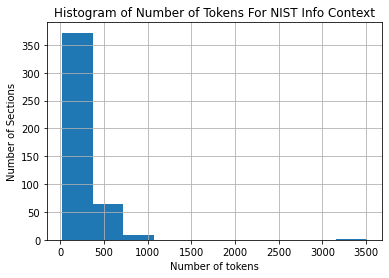

In [10]:
nist_info_df['tokens'] = nist_info_df['context'].apply(count_tokens)

nist_info_df[['tokens']].hist()
plt.xlabel('Number of tokens')
plt.ylabel('Number of Sections')
plt.title('Histogram of Number of Tokens For NIST Info Context')
plt.show()

In [11]:
def write_df_to_csv(df, path):
    """
    Write a dataframe to the given path. If the file already exists, prompts
    the user to confirm overwriting the existing file.

    Args:
        dataframe (pd.DataFrame): The dataframe to write

    Returns:
        str: A message indicating the status of the write attempt
    """
    if os.path.exists(path):
        overwrite = input(f"The file `{path}` already exists. Do you want to overwrite it? Y/(N):\t")
        if overwrite.lower() != 'y':
            return "File not overwritten. Operation cancelled."
        
    try:
        df.to_csv(path, index=False)
        return f"DataFrame sucessfully writen to path '{path}'"
    except Exception as e:
        return f"Error writing DataFrame to path '{path}': {str(e)}"

In [12]:
# Write nist info to csv for storage
write_df_to_csv(nist_info_df, 'data/nist_info.csv')

'File not overwritten. Operation cancelled.'

<a id='wiki_info'></a>  
## Gather Info From Wikipedia

In [13]:
# All wikipedia pages we want to get info from (can add more without issue)
wiki_endpoints = [
    'Computer_security', 'NIST_Cybersecurity_Framework',
    'NIST_Special_Publication_800-53', 'IT_security_standards',
    'National_Institute_of_Standards_and_Technology'
]

def get_wiki_page(title):
    """
    Retrieve a Wikipedia page based on the provided title.

    Args:
        title (str): The title of the Wikipedia page to retrieve.

    Returns:
        WikipediaPage or None: The retrieved WikipediaPage object if the page is found,
        or None if the page does not exist or if an error occurs.

    Raises:
        WikipediaException: If an error occurs while retrieving the Wikipedia page.

    Notes:
        - Code adapted from https://github.com/openai/openai-cookbook/blob/main/examples/fine-tuned_qa/olympics-1-collect-data.ipynb
        - If the provided title matches multiple pages (disambiguation), the function
          retrieves the first option from the disambiguation list.
        - If the provided title does not match any page, the function returns None.
    """
    try:
        return wikipedia.page(title)
    except wikipedia.exceptions.DisambiguationError as e:
        return wikipedia.page(e.options[0])
    except wikipedia.exceptions.PageError as e:
        return None

In [14]:
# get all wikipedia pages
wiki_pages = [get_wiki_page(endpoint.replace('_', ' ')) for\
               endpoint in wiki_endpoints]

In [15]:
# note: all helper functions in this cell are modified from
# https://github.com/openai/openai-cookbook/blob/main/examples/fine-tuned_qa/olympics-1-collect-data.ipynb

# categories within wikipedia pages to ignore
discard_categories = [
    'See also', 'References', 'External links', 'Further reading', "Footnotes",
    "Bibliography", "Sources", "Citations", "Literature", "Footnotes",
    "Notes and references", "Photo gallery", "Works cited", "Photos", "Gallery",
    "Notes", "References and sources", "References and notes"
]

def reduce_long(long_text, long_text_tokens = False, max_len = 590):
    """
    Reduce the length of a long text by truncating it to a maximum number of
    tokens or sentences.

    Args:
        long_text (str): The long text to be reduced.
        long_text_tokens (int or False, optional): The number of tokens in the
            long text. If not provided, it will be calculated using the
            'count_tokens' helper function. Defaults to False.
        max_len (int, optional): The maximum allowed number of tokens.
            Defaults to 590.

    Returns:
        str: The reduced long text.

    Notes:
        - If 'long_text_tokens' is not provided, it will be calculated using the
          'count_tokens' helper function.
        - If the number of tokens in the 'long_text' exceeds 'max_len', the text
          will be truncated to fit within the limit by removing sentences from
          the end.
        - The sentence tokenization is performed using the 'sent_tokenize' 
          function from the nltk library.
    """
    if not long_text_tokens:
        long_text_tokens = count_tokens(long_text)

    if long_text_tokens > max_len:
        # Tokenize the long text into sentences
        sentences = sent_tokenize(long_text.replace("\n", " "))
        ntokens = 0

        # Iterate over the sentences and count the number of tokens
        for i, sentence in enumerate(sentences):
            ntokens += 1 + count_tokens(sentence)
            if ntokens > max_len:
                # Return the truncated long text by joining the selected
                # sentences
                return ". ".join(sentences[:i]) + "."

    return long_text

def extract_sections(
        text,
        title,
        max_len=1500,
        discard_categories=discard_categories):
    """
    Extract sections from a given text based on headings, discarding given
    categories.

    Args:
        text (str): The input text containing sections.
        title (str): The title of the text.
        max_len (int, optional): The maximum length of a section in tokens.
            Defaults to 1500.
        discard_categories (list, optional): Categories to be discarded from the
            extraction process. Defaults to None.

    Returns:
        list: A list of tuples representing the extracted sections. Each tuple
            contains the following elements:
            - (str) The title of the text.
            - (str) The section name.
            - (str) The content of the section.
            - (int) The number of tokens in the section.

    Notes:
        - The extraction process removes equal signs (=) flanking the headings.
        - Sections exceeding the maximum length are truncated using the
          'reduce_long' function.
        - The 'reduce_long' function reduces the length of a long text by
          truncating it to a maximum number of tokens
          or sentences.
    """
    
    if len(text) == 0:
        return []

    # Find and replace all headings with a common pattern
    headings = re.findall("==+ .* ==+", text)
    for heading in headings:
        text = text.replace(heading, "==+ !! ==+")

    # Split the text into sections based on the common pattern
    contents = [c.strip() for c in text.split("==+ !! ==+")]
    assert len(headings) == len(contents) - 1

    cont = contents.pop(0).strip()

    # Add the summary section
    outputs = [(title, "Summary", cont, count_tokens(cont) + 4)]

    max_level = 100
    keep_group_level = max_level
    remove_group_level = max_level
    nheadings, ncontents = [], []
    for heading, content in zip(headings, contents):
        # Remove equal signs flanking header and get the number of equal signs
        plain_heading = " ".join(heading.split(" ")[1:-1])
        num_equals = len(heading.split(" ")[0])
        if num_equals <= keep_group_level:
            keep_group_level = max_level
        
        if num_equals > remove_group_level:
            if num_equals <= keep_group_level:
                continue

        keep_group_level = max_level
        if plain_heading in discard_categories:
            remove_group_level = num_equals
            keep_group_level = max_level
            continue

        nheadings.append(heading.replace("=", "").strip())
        ncontents.append(content)
        remove_group_level = max_level

    # count tokens of each section
    ncontent_ntokens = [
        (
            count_tokens(c) + 3 + 
            count_tokens(" ".join(h.split(" ")[1:-1])) -
            (1 if len(c) == 0 else 0)
        ) for h, c in zip(nheadings, ncontents)
    ]

    # Create tuples of (title, section_name, content, num_tokens) for each section
    outputs += [
        (title, h, c, t) 
        if t < max_len
        else (
            title, 
            h, 
            reduce_long(c, max_len), 
            count_tokens(reduce_long(c,max_len))
        ) for h, c, t in zip(nheadings, ncontents, ncontent_ntokens)
    ]
    return outputs

In [16]:
res = []
# Iterate over each page in the list of wiki_pages
for page in wiki_pages:
    # Extract sections from the page's content using the page's title
    res += extract_sections(page.content, page.title)

# Create a DataFrame from the extracted sections
wiki_df = pd.DataFrame(res, columns=['title', 'heading', 'content', 'tokens'])

# Filter out sections with less than or equal to 40 tokens
wiki_df = wiki_df[wiki_df['tokens'] > 40]

# Drop duplicate sections based on the combination of 'title' and 'heading'
wiki_df = wiki_df.drop_duplicates(['title', 'heading'])

# Reset the index of the DataFrame and drop the original index column
wiki_df = wiki_df.reset_index().drop('index', axis=1)

# Add context column
wiki_df['context'] = wiki_df['title'] + "\n" + wiki_df['heading'] +\
    "\n\n" + wiki_df['content']

wiki_df.sample(8)

,title,heading,content,tokens,context
42,Computer security,Digital hygiene,"Related to end-user training, digital hygiene ...",278,Computer security\nDigital hygiene\n\nRelated ...
68,Computer security,Security analyst,Analyzes and assesses vulnerabilities in the i...,91,Computer security\nSecurity analyst\n\nAnalyze...
40,Computer security,Capabilities and access control lists,"Within computer systems, two of the main secur...",203,Computer security\nCapabilities and access con...
37,Computer security,Hardware protection mechanisms,"While hardware may be a source of insecurity, ...",670,Computer security\nHardware protection mechani...
93,IT security standards,History,Cybersecurity standards have existed over seve...,168,IT security standards\nHistory\n\nCybersecurit...
28,Computer security,Telecommunications,Perhaps the most widely known digitally secure...,174,Computer security\nTelecommunications\n\nPerha...
10,Computer security,Side-channel attack,Any computational system affects its environme...,110,Computer security\nSide-channel attack\n\nAny ...
98,IT security standards,NERC,An initial attempt to create information secur...,147,IT security standards\nNERC\n\nAn initial atte...


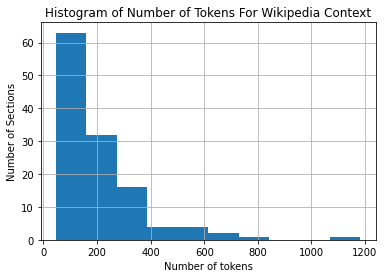

In [17]:
wiki_df[['tokens']].hist()
plt.xlabel('Number of tokens')
plt.ylabel('Number of Sections')
plt.title('Histogram of Number of Tokens For Wikipedia Context')
plt.show()

In [18]:
write_df_to_csv(wiki_df, 'data/wiki_info.csv')

'File not overwritten. Operation cancelled.'

<a id='meta_info'></a>  
## Create Meta Articles

These articles were handwritten and used to give NOVA the ability to answer meta questions. These can be changed to include whatever information is wanted.

In [19]:
# Created with the help of ChatGPT 3.5
# Prompt:
"""
Rewrite this as if I was writing an article on towardsdatascience.com

NOVA is a chatbot primarily focused on assisting in the education of the NIST (National Institute of Standards and Technology) Cybersecurity Framework. While NOVA is capable of
answering questions regarding general cybersecurity topic and questions about other cyberseucrity frameworks, NOVA's expertise lies in the NIST CSF and the related SP 800-53 controls.
Examples of questions NOVA can answer are: "What are the functions of the NIST CSF?" "What is the Identity Function?" "What is the general structure of the NIST CSF?"
NOVA is not capable of answering questions regarding to company or industry-specific implementation. NOVA can give the SP 800-53 controls related to specific cybersecurity problems
but will fail to give concrete examples of implementation details. NOVA should be used as an educational tool in tandem with one's company's existing guidelines or tools and in tandem
with professional consultation. NOVA should not be used as a replacement for professional consultation and does not take responsibility for any issues brought about by users failing to
utilize NOVA in its proper context.
"""

meta_context = []

meta_context.append(
"""
Information about the chatbot NOVA: What NOVA can answer

Abstract: This article details information about what the chatbot NOVA is capable of answering.

Content: In the fast-paced world of cybersecurity, staying up-to-date with the latest frameworks and controls can be a daunting task. That's where NOVA comes in - a chatbot designed to assist in the education of the NIST (National Institute of Standards and Technology) Cybersecurity Framework.

While NOVA is capable of answering general cybersecurity questions and general questions about other frameworks (no specifics), its expertise lies in the NIST CSF and the related SP 800-53 controls. Users can ask NOVA a range of questions, such as "What are the functions of the NIST CSF?" or "What is the Identity Function?" or "What is the general structure of the NIST CSF?"

It's important to note that NOVA is not capable of answering questions related to specific company or industry-specific implementations. However, NOVA can provide users with SP 800-53 controls related to specific cybersecurity problems, albeit without concrete examples of implementation details.

NOVA should be used as an educational tool in conjunction with existing company guidelines or tools and in tandem with professional consultation. It's not intended to replace professional consultation, and users should not solely rely on NOVA for cybersecurity advice. Additionally, NOVA does not take responsibility for any issues brought about by users failing to utilize the chatbot in its proper context.

In conclusion, NOVA is a valuable tool for those seeking to further their knowledge of the NIST CSF and SP 800-53 controls. However, users should always exercise caution and utilize NOVA in conjunction with other resources and professional consultation. With NOVA's help, users can stay informed and up-to-date on the latest cybersecurity frameworks and controls.
"""
)

In [20]:
# Created with the help of ChatGPT 3.5
# Prompt:
"""
Rewrite this as if I was writing an article on towardsdatascience.com

NOVA was created by a Capstone group at the University of Washington iSchool under the sponsorship of KPMG.
The members of the group are: Chris Ong (Software Developer), Daniel Cavazos (Data Scientist),
Matthew Balgan (Software Developer), Connor Fink (Data Scientist), Million Werede (Data Scientist).
If you wish to contact any of the team members, please visit the "Team" page.

After interviewing various members in cybersecurity and students focusing on cybersecurity as well as
researching common painpoints within the industry, the team found that learning and becoming familiar
with the NIST CSF was challenging. In response, the team created NOVA to aid in educating those
attempting to learn the NIST CSF using new and innovative technologies.
"""

meta_context.append(
"""
Information about the chatbot NOVA: Who created NOVA

Abstract: This article details information about who created NOVA and why they created it.

NOVA, the chatbot designed to aid in the education of the NIST (National Institute of Standards and Technology) Cybersecurity Framework, was created by a talented group of students at the University of Washington iSchool. The Capstone group was sponsored by KPMG, a leading professional services firm.

The group comprised five members, each bringing unique skills and perspectives to the project. Chris Ong and Matthew Balgan worked as software developers, while Daniel Cavazos, Connor Fink, and Million Werede were data scientists. If you're interested in learning more about the team and their backgrounds, you can visit the "Team" page.

The group's inspiration for creating NOVA came after conducting interviews with cybersecurity experts and students focusing on cybersecurity. They found that learning and becoming familiar with the NIST CSF was a significant challenge, particularly for those new to the field. To address this issue, the team developed NOVA, leveraging new and innovative technologies to aid in educating those attempting to learn the NIST CSF.

With the creation of NOVA, the team hopes to make cybersecurity education more accessible and engaging. Through their hard work and dedication, they have developed a valuable resource for those seeking to expand their knowledge of the NIST CSF.
"""
)

In [21]:
# Created with the help of ChatGPT 3.5
# Prompt:

"""
Rewrite this as if I was writing an article on towardsdatascience.com

NOVA utilizes the advanced natural language processing capabilities of the OpenAI API. Specifically, NOVA utilizes the embeddings API to find articles cultivated by the team which
most closely relate to the user's prompt. The articles the team used in this process include Wikipedia articles related to cybersecurity and the NIST CSF, detailed information
about the NIST CSF functions, categories, subcategories, and related SP 800-53 controls collected from nist.gov and csf.tools, and questions and answers created by the team
through user testing. The most related articles are fed into OpenAI's gpt-3.5-turbo model instructed to answer users questions using only information found in the articles. If
the information is not available in the given information, the chatbot is instructed to give no answer in response and to instead direct the user towards asking their question in a
different way or asking a different question.
"""

meta_context.append(
"""
Information about the chatbot NOVA: How NOVA was created

Abstract: This article details information about how NOVA was created.

NOVA is a unique chatbot that is designed to assist users in their education of the NIST (National Institute of Standards and Technology) Cybersecurity Framework. One of the ways that NOVA is able to provide valuable assistance is through its use of advanced natural language processing capabilities, which are made possible by the OpenAI API.

Specifically, NOVA utilizes the embeddings API to find articles that are most closely related to the user's prompt. The team behind NOVA has cultivated a wide range of articles to assist in this process, including Wikipedia articles related to cybersecurity and the NIST CSF, detailed information about the NIST CSF functions, categories, subcategories, and related SP 800-53 controls collected from nist.gov and csf.tools, and questions and answers created by the team through user testing.

Once the most relevant articles have been identified, they are fed into OpenAI's powerful gpt-3.5-turbo model. The model is then instructed to answer the user's questions using only information that can be found in the articles. If the information is not available in the given articles, NOVA is programmed to give no answer in response and to instead direct the user towards asking their question in a different way or asking a different question.

Overall, the use of advanced natural language processing capabilities and OpenAI technology makes NOVA an incredibly useful tool for those seeking to learn more about the NIST CSF. By providing accurate and relevant information in response to user questions, NOVA is able to make the learning process more accessible and engaging for everyone.
"""
)

<a id='format_encode'></a>  
## Format and Encode Articles

In [22]:
# global vars, can change model types here
EMBEDDING_MODEL = "text-embedding-ada-002"
GPT_MODEL = "gpt-3.5-turbo"
BATCH_SIZE = 1000

openai.api_key = "API_KEY"
os.environ['OPENAI_API_KEY'] = "API_KEY"

In [ ]:
# Note: code adapted from https://github.com/openai/openai-cookbook/blob/d67c4181abe9dfd871d382930bb778b7014edc66/examples/Embedding_Wikipedia_articles_for_search.ipynb

# embed document chunks
embeddings = []

# Combine the context strings from wiki_df, nist_info_df, and meta_context
# into a single list
context_strings = wiki_df['context'].tolist() +\
    nist_info_df['context'].tolist() + meta_context

# Iterate over the context_strings list in batches
for batch_start in range(0, len(context_strings), BATCH_SIZE):
    batch_end = batch_start + BATCH_SIZE
    batch = context_strings[batch_start:batch_end]
    print(f"Batch {batch_start} to {batch_end-1}")

    # Generate embeddings for the current batch using the
    # specified EMBEDDING_MODEL
    response = openai.Embedding.create(model=EMBEDDING_MODEL, input=batch)

    # Check that the returned embeddings are in the same order as
    # the input batch
    for i, be in enumerate(response["data"]):
        # double check embeddings are in same order as input
        assert i == be["index"]
    # Extract the embeddings from the response and append them to the
    # list of embeddings
    batch_embeddings = [e["embedding"] for e in response["data"]]
    embeddings.extend(batch_embeddings)

# Create a DataFrame with columns "text" and "embedding" using the wiki_strings
# and embeddings
embedded_df = pd.DataFrame({"text": context_strings, "embedding": embeddings})
embedded_df.sample(4)

In [ ]:
# save embedded_df
write_df_to_csv(embedded_df, 'data/embedded_text.csv')